# FOML_ASSIGNMENT_3

    Name:ANTALA AVIRAJ (CS24MTECH14011)

    Question 5_a)Random Forests:

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
import random
from collections import Counter

# Load the dataset we can direct download the data from the website
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
data = pd.read_csv(url, header=None)

# now we need seperate out the features and lables 
X = data.iloc[:, :-1].values  
y = data.iloc[:, -1].values

# Train-test split (as mention in question we use 30% for  test, 70% for train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Decision Tree Class with Entropy
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
    
    def _build_tree(self, X, y, depth=0):
        # If stopping condition is met, return a leaf node
        if len(set(y)) == 1:
            return y[0]
        if self.max_depth is not None and depth >= self.max_depth:
            return Counter(y).most_common(1)[0][0]

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            return Counter(y).most_common(1)[0][0]

        # Split the dataset
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)
    
    def _best_split(self, X, y):
        # we find best split based on the entropy value and information gain
        best_entropy = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])# Here we try to use numpy in maximum cases for faster output 
            for threshold in thresholds:
                left = y[X[:, feature] < threshold]
                right = y[X[:, feature] >= threshold]
                if len(left) == 0 or len(right) == 0:  # this condition prevent empty splits
                    continue
                entropy = self._entropy_impurity(left, right)
                if entropy < best_entropy:
                    best_entropy = entropy
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def _entropy_impurity(self, left, right):
        # we need maximum gain so we need to calculte entropy 
        def entropy(y):
            if len(y) == 0:  
                return 0
            counts = np.bincount(y) # we cal also do this by unique functin or manually 
            probabilities = counts / len(y)
            return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        
        total = len(left) + len(right)
        return (len(left) / total) * entropy(left) + (len(right) / total) * entropy(right)
    
    def predict(self, X):
        return np.array([self._predict_row(row) for row in X])
    
    def _predict_row(self, row):
        node = self.tree
        while isinstance(node, tuple):
            feature, threshold, left_tree, right_tree = node
            if row[feature] < threshold:
                node = left_tree
            else:
                node = right_tree
        return node


# Randomforest class for custom output
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.oob_predictions = None  # we need to make OOB graph in further question so we can stor OOB predictions

    def fit(self, X, y):
        n_samples = X.shape[0]
        # Initialize OOB predictions array
        self.oob_predictions = np.full(n_samples, -1)  # Use -1 to indicate not predicted
        
        for i in range(self.n_estimators):
            # Bootstrap sample
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            oob_indices = np.setdiff1d(np.arange(n_samples), bootstrap_indices)  # OOB indices
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]

            # Subset of features for each treee
            if self.max_features:
                features = np.random.choice(X.shape[1], self.max_features, replace=False)
                X_bootstrap = X_bootstrap[:, features]
            else:
                features = np.arange(X.shape[1])

            # Fit tree
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append((tree, features))

            # here we store predictions for OOB samples
            if len(oob_indices) > 0:
                oob_preds = tree.predict(X[oob_indices][:, features])  # Predict only for OOB samples
                for idx, pred in zip(oob_indices, oob_preds):
                    if self.oob_predictions[idx] == -1:  # Only set if not already predicted
                        self.oob_predictions[idx] = pred

    def oob_error(self, y):
        # Calculate OOB error
        oob_error_rate = np.mean(self.oob_predictions[self.oob_predictions != -1] != y[self.oob_predictions != -1])
        return oob_error_rate

    def predict(self, X):
        tree_preds = np.array([tree.predict(X[:, features]) for tree, features in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_preds)

#now our custom random forest function is completed so we can train and evaluate custom Random Forest
start_time = time.time() # we need to compare so we required time 

custom_rf = RandomForest(n_estimators=100, max_depth=None, max_features=7)
custom_rf.fit(X_train, y_train)
custom_preds = custom_rf.predict(X_test)

end_time = time.time()
custom_time_taken = end_time - start_time
custom_accuracy = accuracy_score(y_test, custom_preds)

print(f"Custom Random Forest Accuracy: {custom_accuracy}")
print(f"Time taken by custom Random Forest: {custom_time_taken:.4f} seconds")
print("___________________________________________________________")

# train and evaluate Scikit-learn's RandomForestClassifier
start_time = time.time()

sklearn_rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=7, random_state=42)
sklearn_rf.fit(X_train, y_train)
sklearn_preds = sklearn_rf.predict(X_test)

end_time = time.time()
sklearn_time_taken = end_time - start_time
sklearn_accuracy = accuracy_score(y_test, sklearn_preds)

print(f"Scikit-learn Random Forest Accuracy: {sklearn_accuracy}")
print(f"Time taken by Scikit-learn Random Forest: {sklearn_time_taken:.4f} seconds")





Custom Random Forest Accuracy: 0.8638667632150615
Time taken by custom Random Forest: 136.9068 seconds
___________________________________________________________
Scikit-learn Random Forest Accuracy: 0.9565532223026793
Time taken by Scikit-learn Random Forest: 0.8679 seconds


    Question 5_b)Random Forests:

max_features: 1, TPR (Sensitivity): 0.0295, Time Taken: 4.9523 seconds
max_features: 4, TPR (Sensitivity): 0.4471, Time Taken: 26.9512 seconds
max_features: 7, TPR (Sensitivity): 0.6655, Time Taken: 54.9254 seconds
max_features: 10, TPR (Sensitivity): 0.8042, Time Taken: 91.0205 seconds
max_features: 13, TPR (Sensitivity): 0.8423, Time Taken: 134.8080 seconds
max_features: 16, TPR (Sensitivity): 0.8804, Time Taken: 158.8658 seconds
max_features: 19, TPR (Sensitivity): 0.9099, Time Taken: 194.5126 seconds
max_features: 22, TPR (Sensitivity): 0.9064, Time Taken: 222.5248 seconds
max_features: 25, TPR (Sensitivity): 0.9237, Time Taken: 266.7548 seconds
max_features: 28, TPR (Sensitivity): 0.9151, Time Taken: 2210.2689 seconds


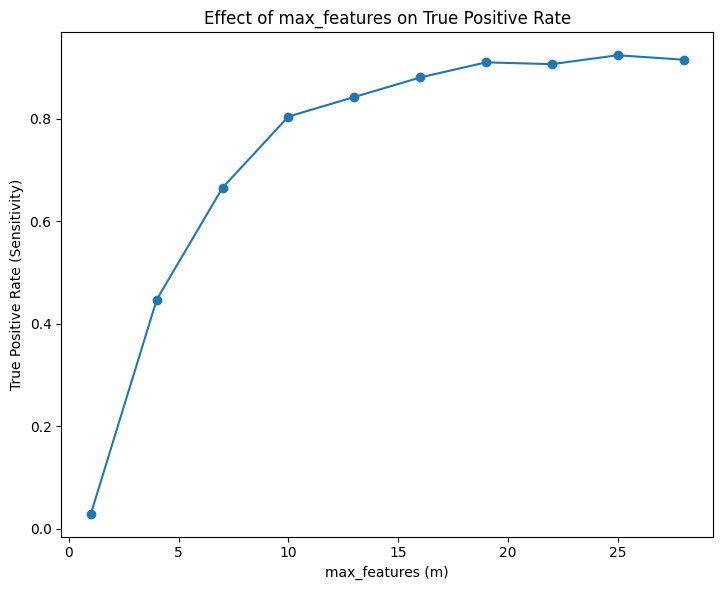

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Here we can interpret this question in 2 manner like first what is the accuracy for the different value of m or
# we can also interpret as like what is sensetivity (True positive rate) graph 

# Function to calculate True Positive Rate
def true_positive_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]  # True Positives (spam correctly identified)
    FN = cm[1, 0]  # False Negatives (spam incorrectly labeled as non-spam)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Calculate TPR
    return TPR

# Function to evaluate Random Forest sensitivity to max_features with TPR
def evaluate_random_forest_sensitivity_with_tpr(max_features_values):
    tpr_values = []
    times_taken = []
    
    for m in max_features_values:
        # For define graph we need to train and evalute random forest 
        start_time = time.time()
        
        custom_rf = RandomForest(n_estimators=50, max_depth=None, max_features=m)
        custom_rf.fit(X_train, y_train)
        custom_preds = custom_rf.predict(X_test)
        
        end_time = time.time()
        time_taken = end_time - start_time
        tpr = true_positive_rate(y_test, custom_preds)
        
        #Store the results
        tpr_values.append(tpr)
        times_taken.append(time_taken)
        
        print(f"max_features: {m}|| TPR (Sensitivity): {tpr:.4f}|| Time Taken: {time_taken:.4f} seconds")
    
    
    plt.figure(figsize=(10, 5))

    # Plot TPR vs. max_features
    plt.subplot(1, 2, 1)
    plt.plot(max_features_values, tpr_values, marker='o')
    plt.xlabel('max_features (m)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Effect of max_features on True Positive Rate')
    
    plt.tight_layout()
    plt.show()


# Define the range of max_features values to test # here i take value 1 to 30(step 3 difference )
max_features_values = list(range(1, 31, 3))

# Evaluate sensitivity to max_features using TPR
evaluate_random_forest_sensitivity_with_tpr(max_features_values)


    Question 5_c)Random Forests:

max_features: 1, OOB Error: 0.3199, Test Error: 0.4084
max_features: 4, OOB Error: 0.2618, Test Error: 0.2187
max_features: 7, OOB Error: 0.2193, Test Error: 0.1093
max_features: 10, OOB Error: 0.1661, Test Error: 0.0775
max_features: 13, OOB Error: 0.1795, Test Error: 0.0644
max_features: 16, OOB Error: 0.1528, Test Error: 0.0565
max_features: 19, OOB Error: 0.1500, Test Error: 0.0529
max_features: 22, OOB Error: 0.1270, Test Error: 0.0456
max_features: 25, OOB Error: 0.1301, Test Error: 0.0485
max_features: 28, OOB Error: 0.1180, Test Error: 0.0449


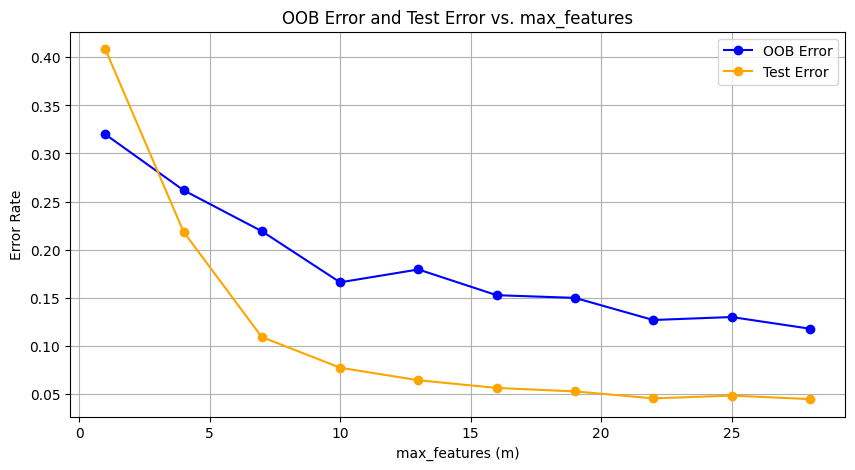

In [3]:
# Evaluate OOB error and test error against max_features
def evaluate_oob_test_error(max_features_values):
    oob_errors = []
    test_errors = []

    for m in max_features_values:
        # Train and evaluate custom Random Forest
        custom_rf = RandomForest(n_estimators=100, max_depth=None, max_features=m)
        custom_rf.fit(X_train, y_train)
        
        # Calculate OOB error
        oob_error = custom_rf.oob_error(y_train)
        oob_errors.append(oob_error)

        # Calculate test error
        test_preds = custom_rf.predict(X_test)
        test_error = 1 - accuracy_score(y_test, test_preds)
        test_errors.append(test_error)

        print(f"max_features: {m}, OOB Error: {oob_error:.4f}, Test Error: {test_error:.4f}")

    # Plot OOB and test errors
    plt.figure(figsize=(10, 5))
    plt.plot(max_features_values, oob_errors, marker='o', label='OOB Error', color='blue')
    plt.plot(max_features_values, test_errors, marker='o', label='Test Error', color='orange')
    plt.xlabel('max_features (m)')
    plt.ylabel('Error Rate')
    plt.title('OOB Error and Test Error vs. max_features')
    plt.legend()
    plt.grid()
    plt.show()

# Define the range of max_features values to test (from 1 to 30 with a step of 3)
max_features_values = list(range(1, 31, 3))

# Evaluate OOB and test error
evaluate_oob_test_error(max_features_values)


    Question 6_a)Gradient Boosting:

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

# Load the datasets
train_df = pd.read_csv('loan_train.csv')
test_df = pd.read_csv('loan_test.csv')

# Filter relevant rows based on `loan_status` and map classes
train_df = train_df[train_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
train_df['loan_status'] = train_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': -1})

test_df = test_df[test_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
test_df['loan_status'] = test_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': -1})
len(train_df.columns.values) # As we know from the data that total number of features is 111

111

* As we know from the data that total number of features is 111

In [3]:
# Drop columns with more than 80% missing values
missing_threshold = 0.8 * len(train_df)
cols_to_drop = [col for col in train_df.columns if train_df[col].isnull().sum() > missing_threshold]
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)
len(train_df.columns.values) # Here If a column has more than 80% of its values missing, it will be dropped.
#Almost 56 columns have 80% of the null values. 

55

* Here If a column has more than 80% of its values missing, it will be dropped.
* Almost 56 columns have 80% of the null values. 

In [4]:
# Separate categorical and numerical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print("Total number of Categorical columns:",len(categorical_cols))
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("Total number of Numerical columns:",len(numerical_cols))
numerical_cols.remove('loan_status') #Here we remove the loan status columns from the data because it represent target value.
print("Numerical columns after removing loan_status:",len(numerical_cols))

Total number of Categorical columns: 22
Total number of Numerical columns: 33
Numerical columns after removing loan_status: 32


In [5]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),# Missing values in numerical columns were filled using the median of each column. 
            ('scaler', StandardScaler()) # The numerical columns were standardized using StandardScaler.
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),#Missing values in categorical columns were filled using the most fre-quent category in each column.
            ('onehot', OneHotEncoder(handle_unknown='ignore'))# Categorical variables were encoded using OneHotEncoder, which created binary columns for each unique category. 
        ]), categorical_cols)
    ])

# Transform the data
X_train = train_df.drop(columns='loan_status')
y_train = train_df['loan_status']
X_test = test_df.drop(columns='loan_status')
y_test = test_df['loan_status']

X_train_transformed = preprocessor.fit_transform(X_train) 
X_test_transformed = preprocessor.transform(X_test)


In [6]:
len(X_train.columns)# Because here we remove one columns loan_status 
# After removing columns with too many missing values, we have 54 features left. 
# This number works well for the data and doesn’t cause overfitting, so it’s a good choice to keep them all.
# Also we can further more features also.

54

* After removing columns with too many missing values, we have 54 features left. 
* This number works well for the data and doesn’t cause overfitting, so it’s a good choice to keep them all.
* Also we can further more features also.

    Question 6_b)Gradient Boosting:

In [8]:
import warnings

# Ignore only UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)


# Parameter grid for Gradient Boosting (reduced for faster testing)
param_grid = {
    'n_estimators': [150, 200, 300, 400, 600, 800, 1000],  # Reduced for quicker testing
    'learning_rate': [0.1],
    'max_depth': [3]
}

# Gradient Boosting Classifier with Grid Search
print("Performing Gradient Boosting Classifier...")
gb_classifier = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_classifier, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=0)

# Fit the model to the training data
grid_search.fit(X_train_transformed, y_train)

# Capture the results of Gradient Boosting Grid Search
results = []
for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    n_estimators = params['n_estimators']
    # Fit the best estimator with the current n_estimators
    y_test_pred_gb = grid_search.best_estimator_.set_params(n_estimators=n_estimators).predict(X_test_transformed)
    precision = precision_score(y_test, y_test_pred_gb, pos_label=1)
    recall = recall_score(y_test, y_test_pred_gb, pos_label=1)
    results.append([n_estimators, mean_score, precision, recall])

# Create DataFrame for Gradient Boosting results
gb_results_df = pd.DataFrame(results, columns=['n_estimators', 'accuracy', 'precision', 'recall'])
print("\nGradient Boosting Results:")
print(gb_results_df)

# Get the Best Gradient Boosting Model
best_gb_model = grid_search.best_estimator_
best_gb_index = grid_search.best_index_

# Display Best Gradient Boosting Model Results
print("__________________________________________________")
print("\nBest Gradient Boosting Model:")
print(gb_results_df.iloc[best_gb_index])
print("__________________________________________________")

# Evaluate Decision Tree Classifier for Comparison
print("\nTraining Decision Tree Classifier...")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_transformed, y_train)

# Predictions for Decision Tree
y_test_pred_dt = dt_classifier.predict(X_test_transformed)

# Decision Tree Performance on Testing Data
dt_accuracy = accuracy_score(y_test, y_test_pred_dt)
dt_precision = precision_score(y_test, y_test_pred_dt, pos_label=1)
dt_recall = recall_score(y_test, y_test_pred_dt, pos_label=1)

# Display Decision Tree Results
print("\nDecision Tree Performance:")
print(f"Accuracy: {dt_accuracy:.6f}")
print(f"Precision: {dt_precision:.6f}")
print(f"Recall: {dt_recall:.6f}")


Performing Gradient Boosting Classifier...



Gradient Boosting Results:
   n_estimators  accuracy  precision  recall
0           150  0.989342   0.988422     1.0
1           200  0.989383   0.988422     1.0
2           300  0.989753   0.988422     1.0
3           400  0.990000   0.988422     1.0
4           600  0.990494   0.988422     1.0
5           800  0.990618   0.988422     1.0
6          1000  0.990741   0.988422     1.0
__________________________________________________

Best Gradient Boosting Model:
n_estimators    1000.000000
accuracy           0.990741
precision          0.988422
recall             1.000000
Name: 6, dtype: float64
__________________________________________________

Training Decision Tree Classifier...

Decision Tree Performance:
Accuracy: 0.990544
Precision: 0.990427
Recall: 0.998515
